In [ ]:
%pip install pymysql
%pip install sshtunnel
%pip install pandas

In [2]:
import pymysql
from sshtunnel import SSHTunnelForwarder
import paramiko
from os.path import expanduser
import pandas as pd

In [3]:
import numpy as np

In [4]:
import time
import matplotlib.pyplot as plt
import math

In [5]:
home = expanduser('~')
mypkey = paramiko.RSAKey.from_private_key_file( home + "/.ssh/id_rsa")

sql_hostname = '127.0.0.1'
sql_username = 'readonly'
sql_password = None
sql_main_database = 'ML3_mirror'
sql_port = 3306
ssh_host = 'flagon.cs.umn.edu'
ssh_user = 'kanna128'
ssh_port = 22
sql_ip = '1.1.1.1.1'

In [6]:
def draw_graph(values, labels, max_vals, scale):
  bars = plt.bar(range(len(values[1])), values[1], color=(0.2, 0.4, 0.6, 0.6))

  if((isinstance(scale[1], int))):
    for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + 0.5*bar.get_width(), yval + values[2], yval)

  xticks = []
  yticks = []

  if(scale[0] != 0):
    xmax = max_vals[0]
    xscale = scale[0]
    for k in np.arange(0, xmax, xscale):
      xticks.append(k)
    plt.xticks(xticks)
  else:
    plt.xticks(range(len(values[0])), values[0])
  
  ymax = max_vals[1]
  yscale = scale[1]

  for k in np.arange(0, ymax, yscale):
    yticks.append(k)
  plt.yticks(yticks)

  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.ylim(0,max_vals[1])

  if(max_vals[0] != 0):
    plt.xlim(0, max_vals[0])
  
  plt.show()

In [7]:
############################################### GLOBAL VARIABLES ############################################
BASELINE = "{\"engineId\":\"baseline\"}"
ITEM_ITEM = "{\"engineId\":\"item-item\"}"
SVD = "{\"engineId\":\"svd\"}"
PICK_GROUPS = "{\"engineId\":\"pick-groups\"}"

LONG_TO_SHORT = {BASELINE: "baseline", ITEM_ITEM: "item-item", SVD:"svd", PICK_GROUPS: "pick-groups"}
SHORT_TO_LONG = {"baseline": BASELINE, "item-item":ITEM_ITEM, "svd":SVD, "pick-groups":PICK_GROUPS}
#############################################################################################################

In [8]:
def read_query(query, conn, field):
    df = pd.read_sql_query(query, conn)
    count = df.count()[field]
    return (df, count)

In [29]:
def primary_dicts(users, users_count, change_events, changes_count):
    ################################## CREATING DICTIONARIES ############################################
    recchange_dict = {} # dict to store key=userId, val=curralg in the iteration process

    changes_dict = {} # needed to later calculate median changes per user
    for k in range(users_count):
        userId = users.at[k, 'userId']
        group = ["{\"engineId\":\""+users.at[k, 'group']+"\"}"] # following the format of log_action.log_Json for future comparisons
        recchange_dict[userId] = group
        changes_dict[userId] = 0
    ########################################################################################################

    # loop to count number of changes correctly; comparing next with prev algorithm
    for i in range(changes_count):
        userId = change_events.at[i, 'userId']
        recalg = change_events.at[i, 'logJson']
        if(recchange_dict[userId][-1] != recalg):
            changes_dict[userId] += 1
            recchange_dict[userId].append(recalg)

    return (changes_dict, recchange_dict)

In [32]:
def fig_2(recchange_dict, changes_dict):
    # count_dict: key=algorithm, val=(no. of users initially assigned, no. of users initially assigned and switched at least once)
    count_dict = {"baseline":[0,0], "item-item":[0,0], "svd":[0,0], "pick-groups":[0,0]}
    for userId,recalg_list in recchange_dict.items():
        recalg = LONG_TO_SHORT[recalg_list[0]]
        count_dict[recalg][0] +=1
        if userId in changes_dict.keys():
            count_dict[recalg][1] += 1
    
    baseline = count_dict["baseline"][1]/count_dict["baseline"][0]
    item_item = count_dict["item-item"][1]/count_dict["item-item"][0]
    svd = count_dict["svd"][1]/count_dict["svd"][0]

    values = [["baseline", "item-item", "svd"], [baseline, item_item, svd], 0.01]
    return (count_dict, values)

In [38]:
def table_2(recchange_dict, count_dict):
    recchange_dict = {key:val for key,val in recchange_dict.items() if len(val)>1}
    patterns = {}
    for userId, recalg_list in recchange_dict.items():
        new_list = []
        for alg in recalg_list:
          new_alg = LONG_TO_SHORT[alg]
          new_list.append(new_alg)
        recalg_tup = tuple(new_list)
        recchange_dict[userId] = recalg_tup
        patterns[recalg_tup] = 0
    
    for recalg_tup in recchange_dict.values():
      patterns[recalg_tup] += 1
    
    patterns_found = set()

    for userId, recalg_tup in recchange_dict.items():
      initial = recalg_tup[0]

      if recalg_tup in patterns.keys():
        count = patterns[recalg_tup]
      if(count>7 and count<53):
        percentage = (count/count_dict[initial][1])*100
        pattern_info = ("pattern: {} | count: {} | percentage: {}".format(recalg_tup, count, percentage))
        patterns_found.add(pattern_info)
    
    for item in patterns_found:
      print(item)
    

connection done
Users: 3005
query done
Recommender change events:  11418
Users switching at least once:  748
Median changes per user w/ at least 1 change:  3


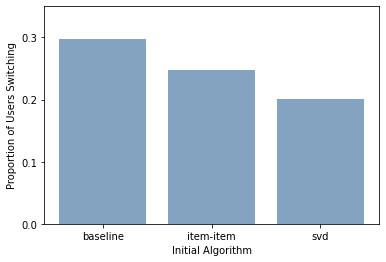

pattern: ('baseline', 'item-item') | count: 45 | percentage: 14.802631578947366
pattern: ('item-item', 'baseline', 'item-item') | count: 8 | percentage: 3.2520325203252036
pattern: ('baseline', 'svd', 'item-item') | count: 8 | percentage: 2.631578947368421
pattern: ('item-item', 'svd') | count: 52 | percentage: 21.138211382113823
pattern: ('svd', 'pick-groups', 'svd') | count: 9 | percentage: 4.545454545454546
pattern: ('baseline', 'svd') | count: 45 | percentage: 14.802631578947366
pattern: ('svd', 'item-item') | count: 30 | percentage: 15.151515151515152
pattern: ('baseline', 'item-item', 'svd', 'item-item') | count: 12 | percentage: 3.9473684210526314
pattern: ('item-item', 'svd', 'item-item') | count: 23 | percentage: 9.34959349593496
pattern: ('item-item', 'pick-groups', 'svd') | count: 8 | percentage: 3.2520325203252036
pattern: ('svd', 'item-item', 'svd') | count: 21 | percentage: 10.606060606060606
pattern: ('baseline', 'item-item', 'svd') | count: 24 | percentage: 7.8947368421

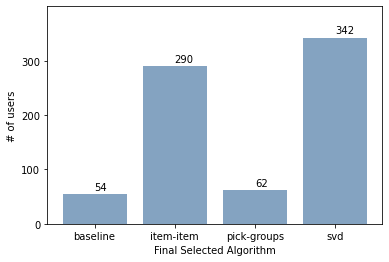

done


In [39]:
def main_func():
  
  # SSH CONNECTION
  with SSHTunnelForwarder(
          (ssh_host, ssh_port),
          ssh_username=ssh_user,
          ssh_pkey=mypkey,
          remote_bind_address=(sql_hostname, sql_port)) as tunnel:
      conn = pymysql.connect(host='127.0.0.1', user=sql_username,
                              passwd=sql_password, db=sql_main_database,
                              port=tunnel.local_bind_port)
      print('connection done')

      # CALCULATING NUMBER OF USERS 
      query_users = ''' SELECT expt_user.group, expt_user.userId from ML3_mirror.expt_user WHERE 
                        exptId = 'listcmp-long' AND started <'2015-04-01' 
                        AND status = 'RANDOMLY_ASSIGNED' '''
      func_out = read_query(query_users, conn, 'group')
      users = func_out[0]
      users_count = func_out[1]
      print("Users: {}".format(users_count))

      # NUMBER OF CHANGE EVENTS 
      query_change = '''SELECT userId, logJson, tstamp, action from ML3_mirror.log_action WHERE EXISTS 
                        (SELECT userId from ML3_mirror.expt_user where expt_user.userId = log_action.userId 
                        AND expt_user.exptId='listcmp-long' 
                        AND expt_user.status='RANDOMLY_ASSIGNED') 
                        AND log_action.action='recommender-change' 
                        AND log_action.tstamp<'2015-04-01' ORDER BY log_action.tstamp'''
      func_out = read_query(query_change, conn, 'userId')
      change_events = func_out[0]
      changes_count = func_out[1]
      print("query done")
      

      # SETTING UP DICTS 
      dicts = primary_dicts(users, users_count, change_events, changes_count)
      changes_dict = dicts[0]
      recchange_dict = dicts[1]


      # TABLE 1
      print("Recommender change events: ", sum(changes_dict.values()))
      changes_dict = {key:val for key,val in changes_dict.items() if val !=0}
      print("Users switching at least once: ", len(changes_dict.values()))
      print("Median changes per user w/ at least 1 change: ", int(np.median(list(changes_dict.values()))))

      
      # FIGURE 2 
      func_out = fig_2(recchange_dict, changes_dict)
      values = func_out[1]
      count_dict = func_out[0]
      draw_graph(values, ["Initial Algorithm", "Proportion of Users Switching"], [0, 0.35], [0, 0.1])


      # TABLE 2 
      table_2(recchange_dict, count_dict)

      # expt_end_date - account_creation_date as a count of days


      # FIGURE 3
      for key in count_dict.keys():
        count_dict[key] = 0

      for userId, recalg_tup in recchange_dict.items():
        if(userId in changes_dict.keys()):
          alg = LONG_TO_SHORT[recalg_tup[-1]]
          count_dict[alg] += 1

      values = [["baseline", "item-item", "pick-groups", "svd"], 
                [count_dict["baseline"], count_dict["item-item"], 
                count_dict["pick-groups"], count_dict["svd"]], 
                8]
      draw_graph(values, ["Final Selected Algorithm", "# of users"], [0, 400], [0, 100])

if __name__ == "__main__":
  main_func()
  print('done')